#  What can python tell us about the upcoming eclipse?

Presented at the 14aug2017 meeting of the Princeton Python User Group: https://www.meetup.com/pug-ip/

To run this notebook from an internet-connected browser, visit
https://mybinder.org/
and enter https://github.com/jsaponara/codingTheEclipse

To run this notebook locally, see the last cell below for ubuntu 16.04 dependencies.

If you just want info about the eclipse without all this coding,
visit https://eclipse2017.nasa.gov/

BUT don't miss how the dancing circles under trees in the breeze become crescents during the eclipse!

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
# pythonistas do astronomy with pyephem
# http://rhodesmill.org/pyephem/
import ephem
from datetime import datetime
# set current date to one week before the eclipse [when this presentation was given]
nowDatetime = datetime.now().replace(year=2017, month=8, day=14)  # 2017aug14
nowEphem = ephem.Date(nowDatetime)

In [7]:
# where is the observer?

import requests
# requests is not built into python but is very popular
# http://docs.python-requests.org/en/master/user/quickstart/

def getLatLon(streetAddr, apiKey = None):
    '''return lat,lon from street address string
        google is more accurate (to the street number) but requires a (free as in beer) key
        openstreetmap is missing our street number but knows our street
        '''
    gglTemplate = 'https://maps.googleapis.com/maps/api/geocode/json?address=%s&key=%s'
    osmTemplate = 'http://nominatim.openstreetmap.org/search?q=%s&format=json'
    if apiKey:
        url = gglTemplate % (streetAddr, apiKey)
    else:
        url = osmTemplate % streetAddr
    r = response = requests.get(url)
    if not r.status_code == requests.codes.ok:
        r.raise_for_status()
    if apiKey:
        # no license embedded, but agreed to before receipt of api key
        return Loc(**r.json()['results'][0]['geometry']['location'])
    else:
        data = r.json()[0]
        # print(data)  # note license in data['licence'] (non-American spelling)
        return dict(lat = data['lat'], lon = data['lon'])

tigerLabsLocation = getLatLon('252 Nassau St, Princeton NJ')
print(tigerLabsLocation)
# {'lat': '40.3491234', 'lon': '-74.6617155'}
# this is just a few blocks away: plenty close enough for astronomy!
# see map by dropping "&format=json" from osm url in browser.
# OSM has 246 Nassau but not 252 Nassau.


{'lon': '-74.6513967', 'lat': '40.3522743'}


In [8]:
# on Aug 21, is there a midafternoon eclipse here?

from math import pi

def createObserverAt(location, date = None):
    obs = ephem.Observer()
    obs.lat = location['lat']
    obs.lon = location['lon']
    if date:
        obs.date = ephem.Date(date)
    return obs
    
sun = ephem.Sun()
moon = ephem.Moon()

# concept: Observer = when + where; when defaults to now
pugipNow = createObserverAt(tigerLabsLocation, nowEphem)
# default date is now
print('now in localtime',ephem.localtime(pugipNow.date).ctime())
# dates default to UTC
print('now in UTC',pugipNow.date)

secondsOfArcPerRadian = (180 / pi) * 60 * 60
# an eclipse is when moon-sun distance is less than the sum of their radii
def isEclipse(m, s, obs):
    m.compute(obs)
    s.compute(obs)
    sep = ephem.separation((m.az, m.alt), (s.az, s.alt))
    sep = sep * secondsOfArcPerRadian
    radii = m.size / 2. + s.size / 2.  # already in seconds of arc
    return sep < radii

# is there an eclipse right now?
answer = 'YES' if isEclipse(moon, sun, pugipNow) else 'no'
print('is there an eclipse right now?',answer)

# is there an eclipse on 21aug at 2pm ET?
duringEclipse = '2017/8/21 18:00:00'  # approximate
pugipDuringEclipse = createObserverAt(tigerLabsLocation, duringEclipse)
#print(ephem.localtime(date).ctime())
answer = 'YES' if isEclipse(moon, sun, pugipDuringEclipse) else 'no'
print('is there an eclipse at 2pm on 21aug?',answer)


now in localtime Mon Aug 14 06:36:46 2017
now in UTC 2017/8/14 10:36:46
is there an eclipse right now? no
is there an eclipse at 2pm on 21aug? YES


In [10]:
# how eclipsed is the sun by the moon at a given time?
# a convenient measure of eclipse-ness is occlusion or overlap
# how do we compute the overlap of two circles?

# shapely is a popular geometry library
# sudo apt install libgeos-dev libgeos++-dev
# sudo pip install shapely

# in shapely, a circle is a point with a radius 'buffer'
from shapely.geometry import Point

def proportionOverlap(m, s, obs):
    m.compute(obs)
    s.compute(obs)
    secondsOfArcPerRadian = (180 / pi) * 60 * 60  # todo how share btw cells?
    #print('moon',float(m.az),float(m.alt),m.size / 2. / secondsOfArcPerRadian)
    #print('sun',float(s.az),float(s.alt),s.size / 2. / secondsOfArcPerRadian)
    #circle = lambda x: Point(float(x.az),float(x.alt)).buffer(x.size / 2. / secondsOfArcPerRadian)
    circle = lambda x: Point(float(x.ra),float(x.dec)).buffer(x.size / 2. / secondsOfArcPerRadian)
    #circle = lambda x: Point(float(x.g_ra),float(x.g_dec)).buffer(x.size / 2. / secondsOfArcPerRadian)
    overlap = circle(m).intersection(circle(s)).area
    return overlap / circle(s).area

print('overlap now:',proportionOverlap(moon, sun, pugipNow))
print('overlap sometime during eclipse:',proportionOverlap(moon, sun, pugipDuringEclipse))


overlap now: 0.0
overlap sometime during eclipse: 0.3028501248173875


In [11]:
# comic relief: we've found that the moon overlaps the sun, 
#   but which is frontmost and which is obscured?

moon2 = ephem.Moon()
try:
    print(moon2.earth_distance)
except Exception as e:
    print('oops:',e)
# ".earth_distance" requires observer, 
#    so it gives the distance at the observer's time

# distance given in AU or astronomical units
moon.compute(pugipNow)
sun.compute(pugipNow)
print('distance now to: sun',sun.earth_distance,'; moon',moon.earth_distance)

# interesting that the sun is farther than average right now [mid-August]
#   in the northern hemisphere's summer
# exercise for the reader: when is the sun farthest from earth?

# let's check that the moon's distance does indeed vary with date
moon.compute(pugipNow)
moon2earthNow = moon.earth_distance
print('distance to moon now:',moon.earth_distance)
moon.compute(pugipDuringEclipse)
moon2earthDuringEclipse = moon.earth_distance
print('distance to moon duringEclipse:',moon.earth_distance)
assert moon2earthNow != moon2earthDuringEclipse

# finally, which is closer during the eclipse?
if moon.earth_distance < sun.earth_distance:
    print('moon obscures sun :)')
else:
    print('sun obscures moon')


oops: field earth_distance undefined until first compute()
distance now to: sun 1.0129140615463257 ; moon 0.00245648087002337
distance to moon now: 0.00245648087002337
distance to moon duringEclipse: 0.0024504016619175673
moon obscures sun :)


In [12]:
# the moon may not obscure 100% of the sun.
# how much of the sun can the moon possibly obscure in the next eclipse?
# at http://www.eclipse2017.org/2017/communities/states/SC/Columbia_1441.htm
#   we see a place and time of totality
columbiaSC = createObserverAt(
    {'lat': '34', 'lon': '-81'},
    ephem.Date('2017-8-21 18:42')
)
print('moon size:',moon.size,'sun size:',sun.size)
print('overlap during totality:',proportionOverlap(moon, sun, columbiaSC))

moon size: 1958.13818359375 sun size: 1894.7916259765625
overlap during totality: 1.0


In [14]:
# when is the peak of the eclipse?

noon = ephem.Date('2017-08-21 16:00:00')  # UTC
#print('noon',ephem.localtime(noon))  # close enough
hoursPerDay = 24
def hoursSinceNoon(ephemDate):
    return (ephemDate - noon) * hoursPerDay

timeDuringEclipse = ephem.Date(duringEclipse)
safeOffset = 12 * ephem.hour
startTime = timeDuringEclipse - safeOffset
endTime   = timeDuringEclipse + safeOffset
pugip = createObserverAt(tigerLabsLocation, startTime)

data = []

while pugip.date < endTime:
    pugip.date += ephem.minute * 5.
    p = proportionOverlap(moon, sun, pugip)
    if p > 0:
        print(ephem.localtime(pugip.date), p)
        data.append((hoursSinceNoon(pugip.date), p))

# we see that the eclipse is 1:25pm - 3:55pm ET
# presumably it peaks around 2:45
# to increase resolution near the maximum,
# let's try every minute from 2:40 to 2:50
pugip.date = ephem.Date('2017/8/21 18:40:00')  # UTC
endTime = pugip.date + 10. * ephem.minute
print()
while pugip.date < endTime:
    pugip.date += 1. * ephem.minute
    p = proportionOverlap(moon, sun, pugip)
    print(ephem.localtime(pugip.date), p)
    data.append((hoursSinceNoon(pugip.date), p))
    
# max overlap [in Princeton NJ] is 73% at 14:44:44 ET

2017-08-21 13:24:59 0.0016466048689543578
2017-08-21 13:29:59 0.02239901948891472
2017-08-21 13:34:59 0.05465939931088016
2017-08-21 13:39:59 0.09464113846281853
2017-08-21 13:44:59 0.1405302005482068
2017-08-21 13:49:59 0.1911228285075431
2017-08-21 13:54:59 0.24550739349787543
2017-08-21 13:59:59 0.3028501169739688
2017-08-21 14:04:59 0.3623671424320946
2017-08-21 14:09:59 0.4231982444059794
2017-08-21 14:14:59 0.48433460198822526
2017-08-21 14:19:59 0.5444758862002506
2017-08-21 14:24:59 0.6018158753767403
2017-08-21 14:29:59 0.6537543382063382
2017-08-21 14:34:59 0.6965095273781075
2017-08-21 14:39:59 0.725156547748265
2017-08-21 14:44:59 0.7347616192383138
2017-08-21 14:49:59 0.723069243796892
2017-08-21 14:54:59 0.6921534398774779
2017-08-21 14:59:59 0.6468104842634079
2017-08-21 15:04:59 0.591865894714422
2017-08-21 15:09:59 0.5310863420667586
2017-08-21 15:14:59 0.46713982521456215
2017-08-21 15:19:59 0.4019132324994213
2017-08-21 15:24:59 0.33686338330572757
2017-08-21 15:29:5

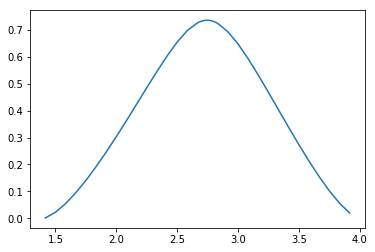

In [12]:
# graph and animate these lists of numbers

#data = sorted(data)
xs, ys = zip(*data)

plt.figure('overlap')
plt.plot(xs, ys)
plt.show()

# we see the maximum overlap is around 2.75 hoursSinceNoon

In [9]:
# how cloudy will it be here?
# let's ask the National Weather Service, weather.gov,
#   as I do at http://websitedeli.com/wsgi/fcst/?loc=08540
import requests
urlTemplate = 'http://forecast.weather.gov/MapClick.php?lat={lat}&lon={lon}&FcstType=digitalDWML'
url = urlTemplate.format(**tigerLabsLocation)
r = response = requests.get(url)
if not r.status_code == requests.codes.ok:
    r.raise_for_status()
xml = r.content
#print(xml[:44])

from lxml import etree
import io
tree = etree.parse(io.BytesIO(xml))
from dateutil.parser import parse as parseDate
forecastTime = tree.xpath('head/product/creation-date/text()')
print('forecast as of',forecastTime)
starttimes=[parseDate(starttime) 
            for starttime in tree.xpath('data/time-layout/start-valid-time/text()')]
#print(starttimes[:5])
els=[el for el in tree.xpath('data/parameters/node()') if type(el)==etree._Element]
#print([el.tag for el in els])
#cloudinessNode = tree.xpath('data/parameters/cloud-amount')[0]
#print(list(cloudinessNode))
#v=list(cloudinessNode)[24]
#print(v.text)
cloudiness = [node.text for node in tree.xpath('data/parameters/cloud-amount')[0]]
#print(cloudiness)
from pprint import pprint
#print(dir(noon))
import pytz
from datetime import timedelta
utc=pytz.UTC
noonDt=utc.localize(noon.datetime())
fivePM=utc.localize(noon.datetime() + timedelta(0, 5 * 60 * 60))
print('cloudiness between noon and 4pm ET at our location')
pprint(list(('%d:%02d' % (tm.hour,tm.minute),'%s%%' % cl) 
            for tm,cl in zip(starttimes,cloudiness) if noonDt < tm < fivePM))
# re-run this cell as the date approaches--the forecast may well change
# if you're using the default date in the past, there is no forecast available, sorry!9

forecast as of ['2017-08-23T18:35:49-04:00']
cloudiness between noon and 4pm ET at our location
[]


In [10]:
# todo
# simulate pinhole camera
#   camera.py simulates camera given a bitmap image
#      https://github.com/smidm/camera.py
#   or maybe use blender, a 3D modeler scriptable in python
#      http://kun-liu.com/blog/graphics/2012/03/17/simulate-real-cameras-in-blender.html
# crescents under tree
#   in the breeze, moving tree leaves create countless shifting 
#   pinhole cameras, each projecting a circular image of the sun onto 
#   the ground (or your screen).  During an eclipse, these circles 
#   become crescents.  Don't miss it!
# light walk--may change the way you think about light and vision
#   https://www.exploratorium.edu/bob-miller/light-walk
#   [the exploratorium led science museums into the "please touch" era]
# next eclipse: 08apr2024
#   https://eclipse.gsfc.nasa.gov/SEgoogle/SEgoogle2001/SE2024Apr08Tgoogle.html
# understand better:
#   Apparent geocentric position: g_ra and g_dec
#     where the object will "appear" for an observer at the center of the Earth
#   Apparent topocentric position: ra and dec
#     apparent position of the body as seen by the Observer on the surface of the Earth

# admin todo
#   run jupyter notebook run in a virtualenv so we can pip install without sudo access

In [11]:
# to run this notebook locally on ubuntu 16.04

# sudo apt install python3-pip
# sudo pip3 install --upgrade pip3
# sudo apt install libgeos-dev libgeos++-dev
# sudo -H pip3 install shapely
# sudo -H pip3 install jupyter
# sudo -H pip3 install requests
# sudo -H pip3 install pyephem
# sudo jupyter nbextension enable --py --sys-prefix widgetsnbextension
# sudo -H pip3 install matplotlib
# [cd to folder with notebook]
# jupyter-notebook
# [click on notebook file]